In [ ]:
# PACKAGE: DO NOT EDIT
import numpy as np
import matplotlib
import sklearn
import sklearn.datasets
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
import time
import timeit

In [ ]:
%matplotlib inline
from ipywidgets import interact

Next, we are going to retrieve Olivetti faces dataset.

When working with some datasets, before digging into further analysis, it is almost always useful to do a few things to understand your dataset. First of all, answer the following set of questions:

What is the size of your dataset?
What is the dimensionality of your data?
The dataset we have are usually stored as 2D matrices, then it would be really important to know which dimension represents the dimension of the dataset, and which represents the data points in the dataset.

In [ ]:
image_shape = (64, 64)
# Load faces data
dataset = fetch_olivetti_faces()
faces = dataset.data

print('Shape of the faces dataset: {}'.format(faces.shape))
print('{} data points'.format(faces.shape[0]))

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Shape of the faces dataset: (400, 4096)
400 data points


In [ ]:
@interact(n=(0, len(faces)-1))
def display_faces(n=0):
    plt.figure()
    plt.imshow(faces[n].reshape((64, 64)), cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=0, description='n', max=399), Output()), _dom_classes=('widget-interact'…

## **1. Mean and Covariance of a Dataset**

In [ ]:
def mean_naive(X):
   
    N, D = X.shape
    calc = np.zeros(D)
    for n in range(N):
        calc += X[n] # EDIT THIS
    mean = calc / N
    return mean




def cov_naive(X):
    N, D = X.shape
    calc = np.zeros((D, D))
    mean = mean_naive(X)
    for n in range(N):
        diff = np.asmatrix(X[n] - mean)
        calc += diff.T @ diff # EDIT THIS
    covariance = calc / N
    return covariance

In [ ]:
def mean(X):
    mean = np.mean(X, axis=0) # EDIT THIS
    return mean
 

def cov(X):
    N, D = X.shape
    covariance_matrix = np.cov(X, rowvar=False)
    return covariance_matrix


With the mean function implemented, let's take a look at the mean face of our dataset!

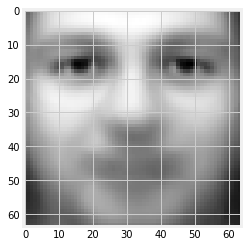

In [ ]:
def mean_face(faces):
    mean_face = mean(faces)
    return mean_face

plt.imshow(mean_face(faces).reshape((64, 64)), cmap='gray');

To put things into perspective, we can benchmark the two different implementation with the %time function in the following way:

In [ ]:
# We have some huge data matrix, and we want to compute its mean
X = np.random.randn(100000, 20)
# Benchmarking time for computing mean
%time mean_naive(X)
%time mean(X)
pass

CPU times: user 119 ms, sys: 0 ns, total: 119 ms
Wall time: 119 ms
CPU times: user 3.03 ms, sys: 0 ns, total: 3.03 ms
Wall time: 3.04 ms


In [ ]:
# Benchmarking time for computing covariance
%time cov_naive(X)
%time cov(X)
pass

CPU times: user 1.65 s, sys: 1.76 ms, total: 1.65 s
Wall time: 1.66 s
CPU times: user 20.9 ms, sys: 9.14 ms, total: 30.1 ms
Wall time: 22.1 ms


**We can  see how running time increases as we increase the size of our dataset. **



In [ ]:
def time(f, repeat=100):
    """A helper function to time the execution of a function.
    
    Arguments
    ---------
    f: a function which we want to time it.
    repeat: the number of times we want to execute `f`
    
    Returns
    -------
    the mean and standard deviation of the execution.
    """
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

In [ ]:
fast_time = []
slow_time = []

for size in np.arange(100, 5000, step=100):
    X = np.random.randn(size, 20)
    f = lambda : mean(X)
    mu, sigma = time(f)
    fast_time.append((size, mu, sigma))
    
    f = lambda : mean_naive(X)
    mu, sigma = time(f)
    slow_time.append((size, mu, sigma))

fast_time = np.array(fast_time)
slow_time = np.array(slow_time)

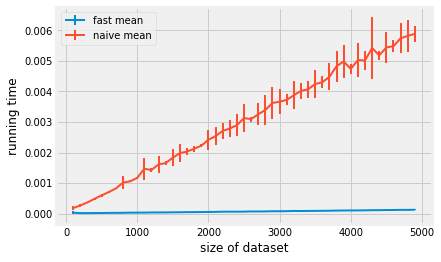

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(fast_time[:,0], fast_time[:,1], fast_time[:,2], label='fast mean', linewidth=2)
ax.errorbar(slow_time[:,0], slow_time[:,1], slow_time[:,2], label='naive mean', linewidth=2)
ax.set_xlabel('size of dataset')
ax.set_ylabel('running time')
plt.legend();

In [ ]:
fast_time_cov = []
slow_time_cov = []

for size in np.arange(100, 5000, step=100):
    X = np.random.randn(size, 20)
    f = lambda : cov(X)   
    mu, sigma = time(f)
    fast_time_cov.append((size, mu, sigma))
    
    f = lambda : cov_naive(X)  
    mu, sigma = time(f) 
    slow_time_cov.append((size, mu, sigma))

fast_time_cov = np.array(fast_time_cov)
slow_time_cov = np.array(slow_time_cov)

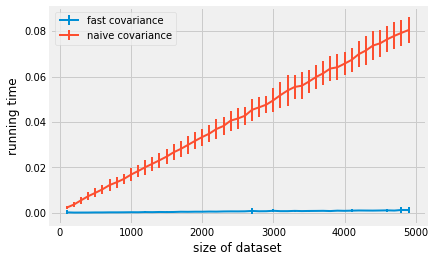

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(fast_time_cov[:,0], fast_time_cov[:,1], fast_time_cov[:,2], label='fast covariance', linewidth=2)
ax.errorbar(slow_time_cov[:,0], slow_time_cov[:,1], slow_time_cov[:,2], label='naive covariance', linewidth=2)
ax.set_xlabel('size of dataset')
ax.set_ylabel('running time')
plt.legend();

We see the makrked difference!!

## **2. Affine Transformation of Dataset**

Discussing ablut the mean and covariance of affine transformation of random variables.

Consider a data matrix **X** of size (N, D). We would like to know what is the covariance when we apply an affine transformation $\boldsymbol{A}\boldsymbol{x}_i + \boldsymbol{b}$ with a matrix $\boldsymbol A$ and a vector $\boldsymbol b$ to each datapoint $\boldsymbol{x}_i$ in $\boldsymbol{X}$, i.e. we would like to know what happens to the mean and covariance for the new dataset if we apply affine transformation.

In [21]:
def affine_mean(mean, A, b):
    """Compute the mean after affine transformation
    Args:
        mean: ndarray, the mean vector
        A, b: affine transformation applied to x
    Returns:
        mean vector after affine transformation
    """
    affine_m = A @ mean + b 
    return affine_m

def affine_covariance(S, A, b):
    """Compute the covariance matrix after affine transformation
    Args:
        S: ndarray, the covariance matrix
        A, b: affine transformation applied to each element in X        
    Returns:
        covariance matrix after the transformation
    """
    affine_cov = A @ S @ A.T
    return affine_cov

Once the two functions above are implemented, we can verify the correctness our implementation.

In [23]:
random = np.random.RandomState(42)
A = random.randn(4,4)
b = random.randn(4)

In [24]:
X = random.randn(100, 4)

In [25]:
X1 = ((A @ (X.T)).T + b)  # applying affine transformation once
X2 = ((A @ (X1.T)).T + b) # and again

One very useful way to compare whether arrays are equal/similar is use the helper functions in numpy.testing. the functions in numpy.testing will throw an AssertionError when the output does not satisfy the assertion.

In [26]:
np.testing.assert_almost_equal(mean(X1), affine_mean(mean(X), A, b))
np.testing.assert_almost_equal(cov(X1),  affine_covariance(cov(X), A, b))
print('correct')

correct


In [27]:

np.testing.assert_almost_equal(mean(X2), affine_mean(mean(X1), A, b))
np.testing.assert_almost_equal(cov(X2),  affine_covariance(cov(X1), A, b))
print('correct')

correct
